<a href="https://colab.research.google.com/github/sunyeul/ToyProjectLab/blob/feature%2Funprompted_controlnet_hands-on/ControlNet/Unprompted_ControlNet_Hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unprompted Control

- Stable Diffusion 2.1 Inpainting
- ControlNet Canny
- [Scratch Detection](https://github.com/microsoft/Bringing-Old-Photos-Back-to-Life)

https://github.com/vijishmadhavan/UnpromptedControl

![](https://raw.githubusercontent.com/vijishmadhavan/UnpromptedControl/master/examples/eg2gif.gif)

![](https://github.com/vijishmadhavan/UnpromptedControl/raw/master/examples/objgif.gif)

In [ ]:
#@title Install requirements

!git clone https://github.com/vijishmadhavan/UnpromptedControl
%cd UnpromptedControl
!pip install -qq diffusers==0.14.0 xformers transformers scipy ftfy accelerate controlnet_aux
!pip install -qq opencv-contrib-python

# 2020年に発表された論文「Old Photo Restoration」で使用されたスクラッチ探知モデル（U-Net）
# https://github.com/microsoft/Bringing-Old-Photos-Back-to-Life
!wget -q https://www.dropbox.com/s/5jencqq4h59fbtb/FT_Epoch_latest.pt

Cloning into 'UnpromptedControl'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 183 (delta 86), reused 78 (delta 18), pack-reused 0
Receiving objects: 100% (183/183), 5.55 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/UnpromptedControl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 M

In [ ]:
#@title Load Models

import numpy as np
import torch
from src.pipeline_stable_diffusion_controlnet_inpaint import *
from scratch_detection import ScratchDetection, process_images
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, DEISMultistepScheduler
from diffusers.utils import load_image
from PIL import Image
import cv2
import time
import os

device = "cuda"

# ControlNet Cannyダウンロード
controlnet = ControlNetModel.from_pretrained("thepowefuldeez/sd21-controlnet-canny", torch_dtype=torch.float16)

# SD Inpaintingモデルダウンロード
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)

# speed up diffusion process with faster scheduler and memory optimization
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()
pipe.to('cuda')

print("Models loaded successfully!")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Models loaded successfully!


# Image

In [ ]:
!wget -q https://github.com/microsoft/Bringing-Old-Photos-Back-to-Life/blob/master/test_images/old_w_scratch/a.png?raw=true -O /content/test.png

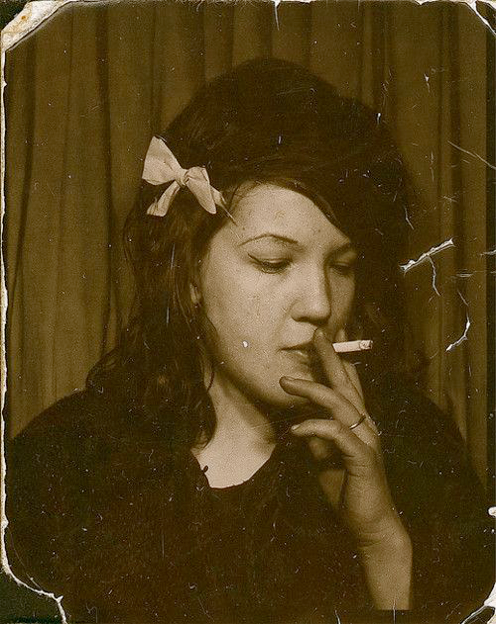

In [ ]:
img = Image.open("/content/test.png").convert("RGB")

img

## Detect scratches from the image

initializing the dataloader
model weights loaded
directory of testing image: /content
processing .config
Skipping non-file .config
processing UnpromptedControl
Skipping non-file UnpromptedControl
processing sample_data
Skipping non-file sample_data
processing test.png


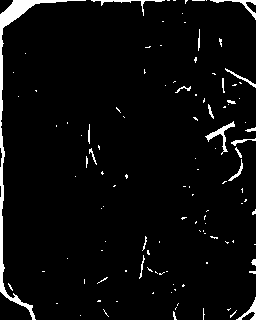

In [ ]:
process_images("/content", "/content/mask", input_size="scale_256", gpu=0)

mask_img = Image.open("/content/mask/mask/test.png")

mask_img

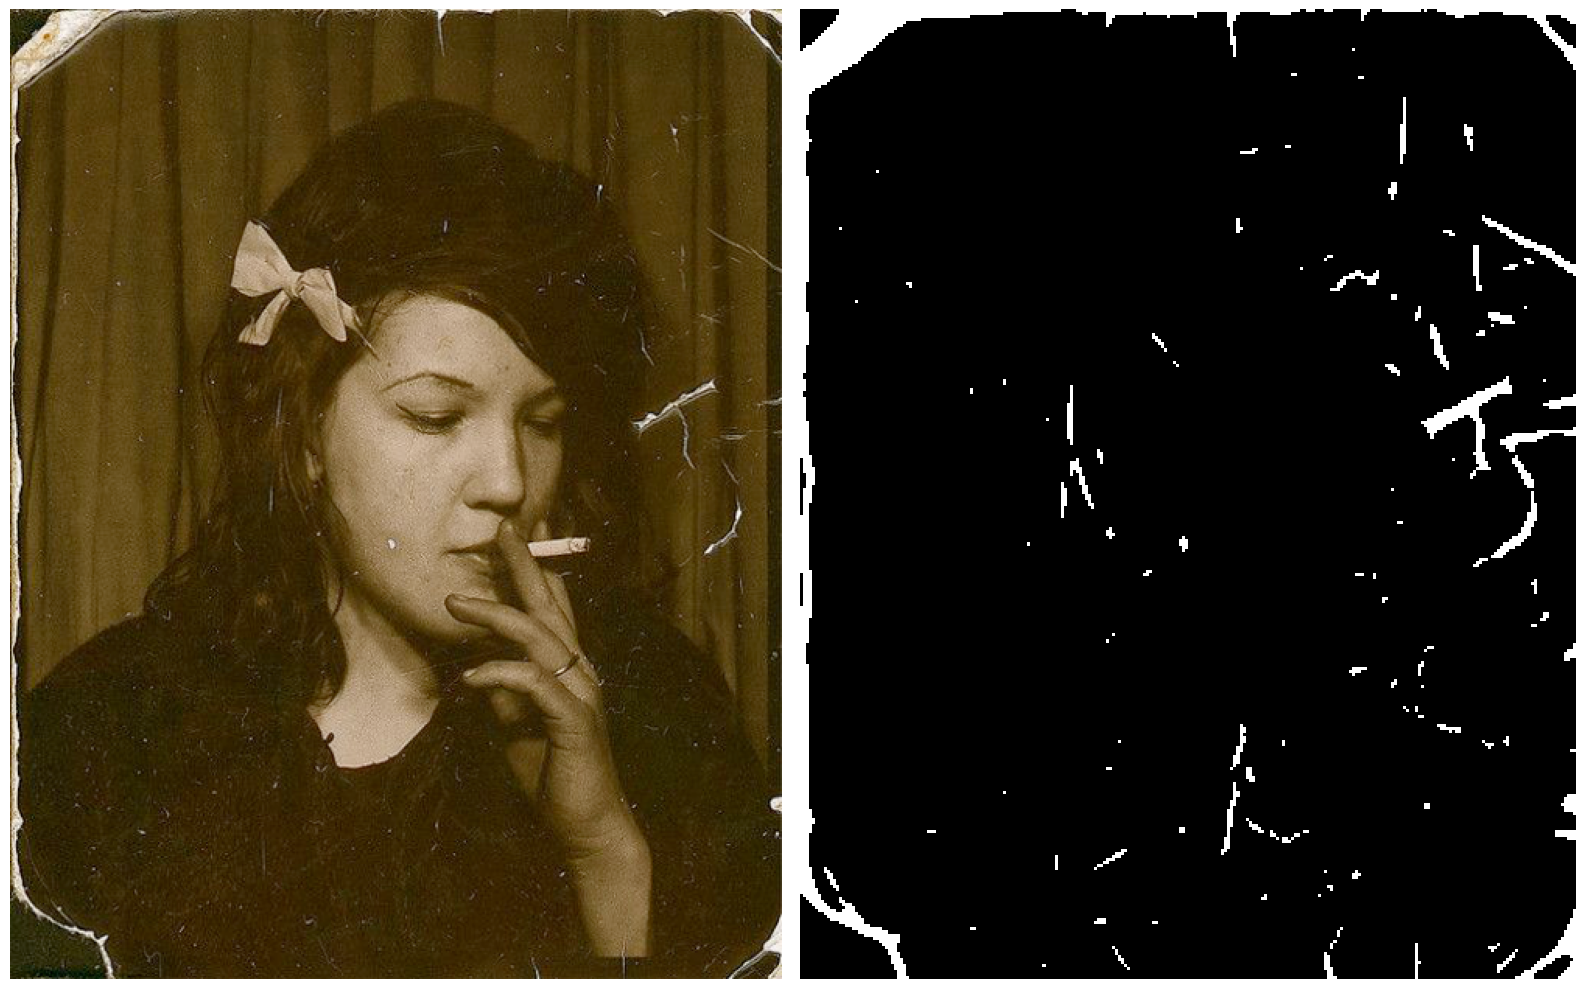

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(img)
axes[1].imshow(mask_img)
axes[0].axis("off")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Dilated the mask image

- スクラッチの領域を少し膨らませた方がより自然がアウトプットが得られる
- kernelとiterationsで調整できる

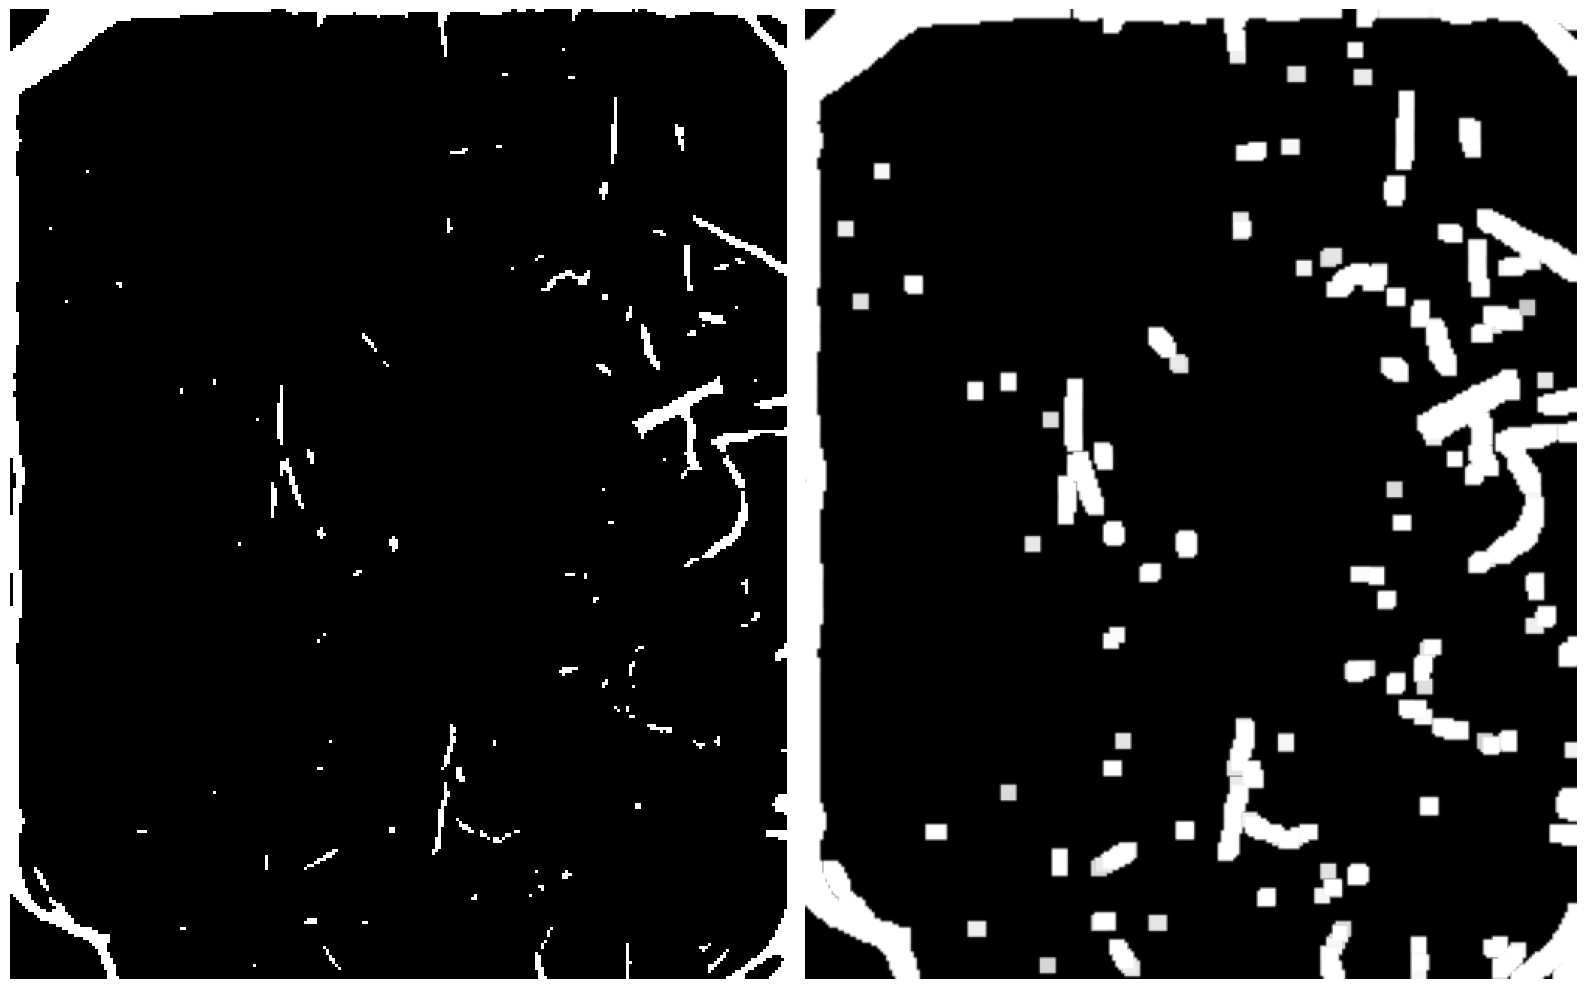

In [ ]:
mask_img_resized = mask_img.resize(img.size, Image.BICUBIC)

# Apply dilation to make the lines bigger
kernel = np.ones((5, 5), np.uint8)
mask_img_np = np.array(mask_img_resized)
mask_img_np_dilated = cv2.dilate(mask_img_np, kernel, iterations=2)
mask_img_dilated = Image.fromarray(mask_img_np_dilated)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(mask_img)
axes[1].imshow(mask_img_dilated)
axes[0].axis("off")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Canny edge detection from the image

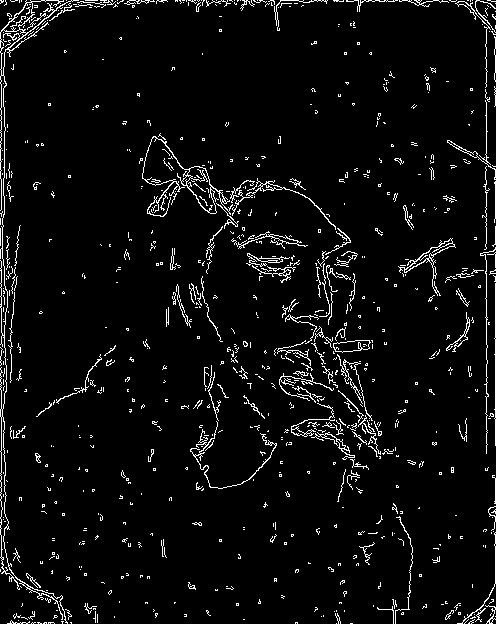

In [ ]:
input_img = np.array(img)

low_threshold = 100
high_threshold = 200
canny = cv2.Canny(input_img, low_threshold, high_threshold)
canny = canny[:, :, None]
canny = np.concatenate([canny, canny, canny], axis=2)
canny_img = Image.fromarray(canny)

canny_img

## Inpaint with Stable Diffusion ControlNet

- 全ての結果物をInpainting SDモデルに与える
- モデルはCanny Edge Detectionを参考にしながらScratch Mask Detectionを埋める
    - Scratch Mask Detection -> 何をInpaintするか？
    - Canny Edge Detection -> どうやってInpaintするか？
- promptは与えない（書いても効果なし）

  0%|          | 0/200 [00:00<?, ?it/s]

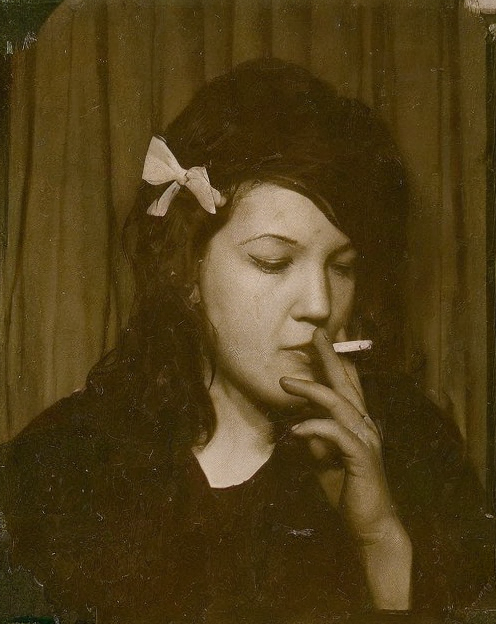

In [ ]:
output = pipe(
    prompt="",  # プロンプトはなし
    num_inference_steps=200,  # default: 20
    generator=torch.manual_seed(0),  # seed
    image=input_img,  # 原本の画像
    control_image=canny_img,  # Canny Edge Detection
    controlnet_conditioning_scale=0,
    mask_image=mask_img_dilated,  # Scratch Mask Detection
).images[0]

output

## Result

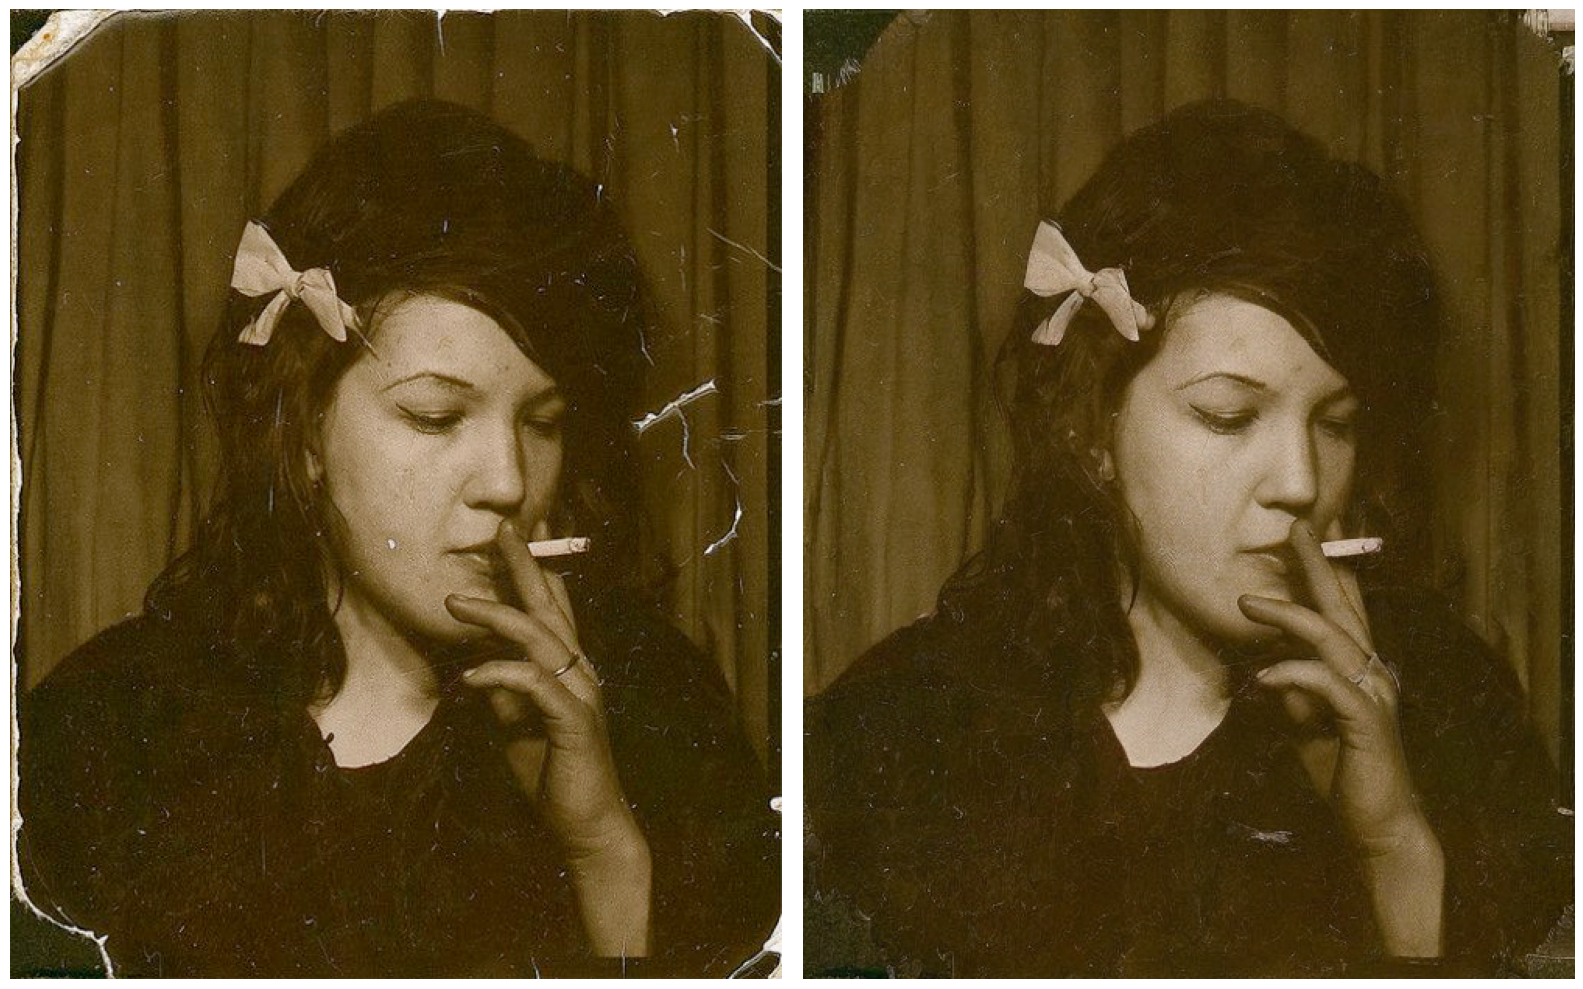

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(img)
axes[1].imshow(output)
axes[0].axis("off")
axes[1].axis("off")
plt.tight_layout()
plt.show()